In [3]:
# Import general needed libraries
import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# Import necessary libraries for optimization procedure
from typing import NamedTuple
from diffilqrax import ilqr
from diffilqrax.utils import initialise_stable_dynamics, keygen
from diffilqrax.ilqr import ilqr_solver
from diffilqrax.typs import (
    iLQRParams,
    Theta,
    System,
    ModelDims,
)

jax.config.update('jax_enable_x64', True)

# Generate keys
key = jr.PRNGKey(seed=0)
key, skeys = keygen(key, 1)

In [40]:
# Class for storing Arm parameters
class ArmParams():
    def __init__(self):
        """
        """
        # Define physical properties of arm model
        #TODO: Make this an argument
        # arm lengths
        self.L1, self.L2 = 0.30, 0.30 #m
        # arm masses
        M1, M2 = 1.4, 1.0 #kg
        # moments of inertia
        I1, I2 = .025, .045 #kg/m^2
        # center of mass for lower arm
        D2 = .16 #m

        # constants for dynamics
        self.a1 = jnp.array(I1 + I2 + (M2*self.L1**2))
        self.a2 = jnp.array((M2*self.L1*D2))
        self.a3 = jnp.array(I2)

        # Constant damping matrix
        self.B = jnp.array(
            [(.05, .025),
            (.025, .05)]
        )

        # step size
        self.dt = .001

        # Initial Task
        self.init_radial_task()
        
        #TODO: Add Theta Constraints Here
        self.max_theta = jnp.array([jnp.pi])
        self.min_theta = jnp.array([0.])
        
    # Define functions to calculate matrices for forward dynamics
    def calc_dyn_mats(self, theta1, theta2, dtheta1, dtheta2):
        """
        """
        # Update Matrix of inertia
        m_theta = jnp.array(
            [(self.a1+2*self.a2*jnp.cos(theta2), self.a3+arm_params.a2*jnp.cos(theta2)),
            (self.a3+self.a2*jnp.cos(theta2), self.a3)]
        )
        # Update Centripetal and Coriolis forces
        C = (self.a2*jnp.sin(theta2)) * jnp.array(
            [(-dtheta2*(2*dtheta1+dtheta2)), (dtheta1**2)]
        ).reshape(-1,1)

        return m_theta, C

    # Define function for calculating arm positions
    def calc_arm_pos(self, thetas):
        """
        """
        # Extract necessary state vars
        theta1, theta2 = thetas
        # Calculate positions and return
        elbow_pos = jnp.array([
            (self.L1*jnp.cos(theta1)), (self.L1*jnp.sin(theta1))
        ]).squeeze()
        
        hand_pos = jnp.array(
            [(elbow_pos[0] + self.L2*jnp.cos(theta1+theta2)),
             (elbow_pos[1] + self.L2*jnp.sin(theta1+theta2))]
        ).squeeze()

        return jnp.vstack([hand_pos, elbow_pos])
    
    def get_angles_from_pos(self, pos):
        """
        """
        x, y = pos
        theta1 = jnp.arctan2(y, x) - jnp.arccos((x**2 + y**2 + self.L1**2 - self.L2**2)
                                                         /(2*self.L1*(x**2 + y**2)**0.5))
        theta2 = jnp.arccos((x**2 + y**2 - self.L1**2 - self.L2**2)/(2*self.L1*self.L2))
        
        return theta1, theta2

    def init_radial_task(self, start_pos=jnp.array([0.0, 0.4]), radius=0.12):
        """
        """
        # Set starting positions
        x0, y0 = start_pos

        # Get target locations
        target_angles = jnp.array([0., 45., 90., 135., 180., 225., 270., 315.])*(2*jnp.pi/360)
        target_x = x0 + (jnp.cos(target_angles)*radius)
        target_y = y0 + (jnp.sin(target_angles)*radius)
        self.targets = jnp.concat([target_x[:, None], target_y[:, None]], axis=1) #m

        # Get initial angles from starting position
        theta1, theta2 = self.get_angles_from_pos(start_pos)
        self.init_thetas = jnp.vstack([theta1, theta2])
        
        # Store arm angles for targets
        target_t1, target_t2 = jax.vmap(self.get_angles_from_pos)(self.targets)
        self.target_angles = jnp.hstack([target_t1[:, None], target_t2[:, None]])
#         self.target = jr.choice(key, arm_params.target_angles).reshape(-1,1)

    def plot_task_state(self, pos, ax=None):
        """
        """
        targets = self.targets * 100 #cm
        
        # Create figure if not given
        if ax == None:
            fig, ax = plt.subplots()
        else:
            ax.clear()
            
        # Convert positions to cm
        pos_cm = pos*100
        
        # Target locations
        ax.scatter(targets[:, 0], targets[:, 1], marker='s', color='green', s=200) #TODO, figure out how big these need to be

        # Start Locations
        ax.scatter(0., 0., color='red') # Shoulder
        ax.scatter(pos_cm[0, 0], pos_cm[0, 1], color='blue') # Hand
        ax.scatter(pos_cm[1, 0], pos_cm[1, 1], color='green') # Elbow

        # Make arms by connecting joints
        ax.plot([0., pos_cm[1, 0]], [0., pos_cm[1, 1]], color='blue') # Lower Arm
        ax.plot([pos_cm[0, 0], pos_cm[1, 0]], [pos_cm[0, 1], pos_cm[1, 1]], color='blue') # Upper Arm
        
        # Set axis boundaries
        ax.set_xlim([-60, 60])
        ax.set_ylim([-30, 60])
        
        if ax == None:
            plt.show()
        else:
            return ax
        

In [41]:
arm_params = ArmParams()
arm_params.target = jr.choice(key, arm_params.target_angles).reshape(-1,1)
init_state = jnp.vstack([arm_params.init_thetas, 0., 0.])
torques = jnp.ones((2,1)) * 10 

In [42]:
arm_params.target

Array([[0.4783833 ],
       [1.60191246]], dtype=float64)

In [43]:
init_state

Array([[0.72972766],
       [1.68213734],
       [0.        ],
       [0.        ]], dtype=float64)

<IPython.core.display.Javascript object>


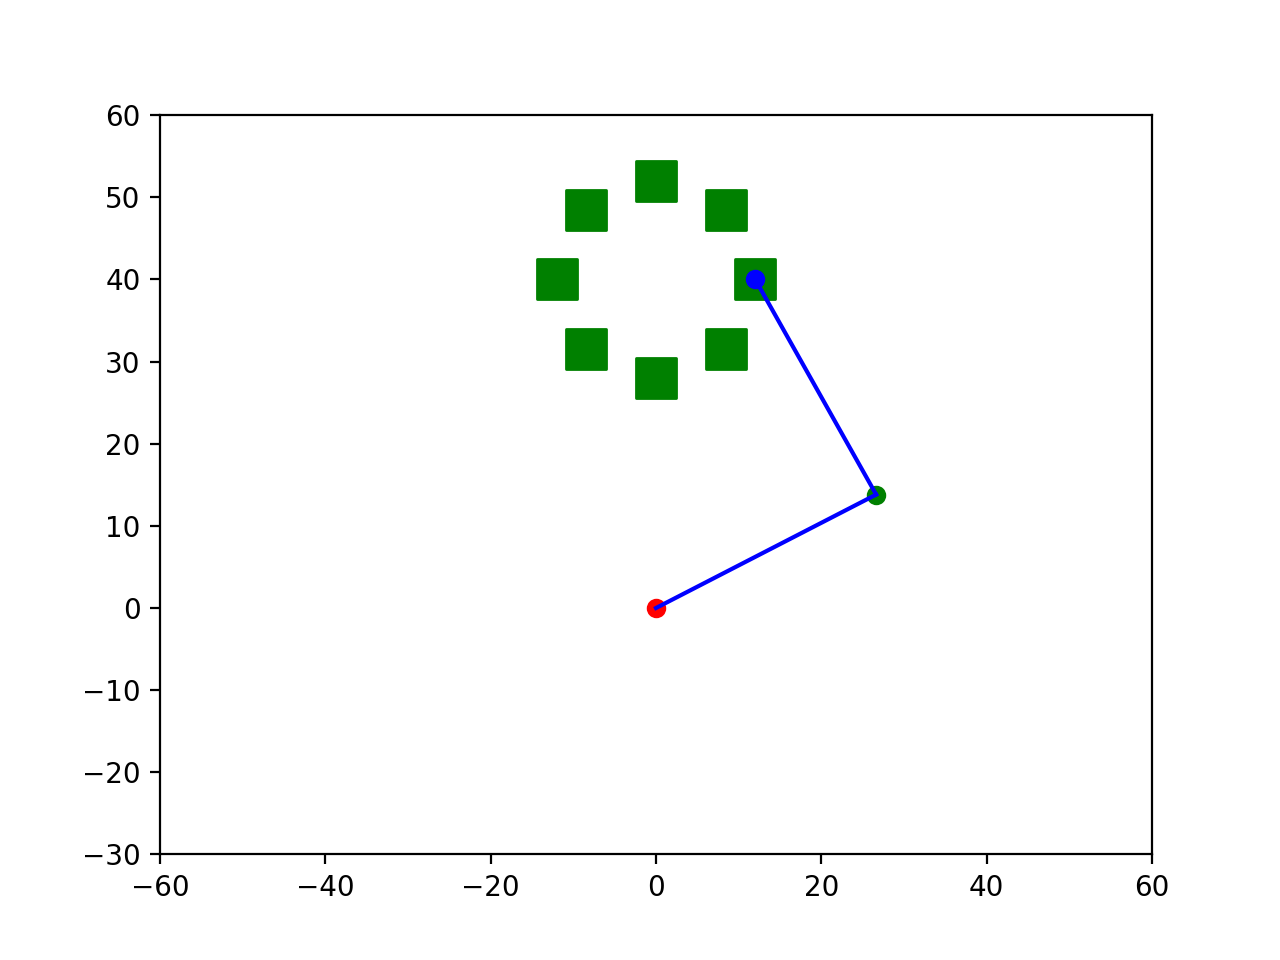

<Axes: >

In [44]:
arm_params.plot_task_state(arm_params.calc_arm_pos(arm_params.target))

In [45]:
from functools import partial
from jax import jit

def check_bounds(n_state, params):
    """
    Check if theta1 and theta2 are out of biomechanical-ish bounds.
    """
    
    # Check thetas against upper bound
    n_state = n_state.at[0].set(jax.lax.select(n_state[0] > params.max_theta, params.max_theta, n_state[0]))
    n_state = n_state.at[1].set(jax.lax.select(n_state[1] > params.max_theta, params.max_theta, n_state[1]))
    
    # Check thetas against lower bound
    n_state = n_state.at[0].set(jax.lax.select(n_state[0] < params.min_theta, params.min_theta, n_state[0]))
    n_state = n_state.at[1].set(jax.lax.select(n_state[1] < params.min_theta, params.min_theta, n_state[1]))
    
    # Set angular velocities to 0 if bounds are reached
    n_state = n_state.at[2].set(
        jax.lax.select(
            jnp.logical_or(n_state[0] == params.min_theta, n_state[0] == params.max_theta),
            jnp.array([0.]),
            n_state[2]
        )
    )
    n_state = n_state.at[3].set(
        jax.lax.select(
            jnp.logical_or(n_state[1] == params.min_theta, n_state[1] == params.max_theta),
            jnp.array([0.]),
            n_state[3]
        )
    )
    
    return n_state

# Define dynamics step
def arm_step(torques, state, arm_params):
    """
    """
    # extract state vars
    theta1, theta2, dtheta1, dtheta2 = state
    # Get only angular velocities
    dthetas = state[2:].reshape(-1, 1)
    # Update dynamics matrices
    m_theta, C = arm_params.calc_dyn_mats(
        theta1.squeeze(), theta2.squeeze(), dtheta1.squeeze(), dtheta2.squeeze()
    )
    # Forward dynamics of torques applied to arm
    #NOTE: angular velocities blowing up to inf, something to do with inverse here I think!
    d2thetas = jnp.linalg.inv(m_theta) @ (torques - C + (arm_params.B@dthetas))
    # New state
    dstate = jnp.vstack([dthetas, d2thetas])

    # Update state (TODO: May want to use a more powerful integration method)
    # Is it wrapping around here cause dstate is so large?
    n_state = state + arm_params.dt*dstate
    
    # Check Bounds
    n_state = check_bounds(n_state, arm_params)
    
    return n_state, dstate
    

In [46]:
# define system dimensions
dims = ModelDims(horizon=5000, n=2, m=2, dt=0.001)

In [51]:
def rollout(dyn_step, Us, state_init, prms):
    def fwd_step(state, inputs):
        u = inputs.reshape(-1,1)
        x = state
        nx, dnx = dyn_step(u, x, prms)
        return (nx), (nx, u, dnx)

    xf, (state_traj, input_traj, dstate_traj) = jax.lax.scan(fwd_step, init=state_init, xs=Us)

    return jnp.vstack([state_init[None], state_traj]), input_traj, dstate_traj

In [52]:
# Define initial control sequence
# Input Pulse
# u_init = jnp.concat(
#     [jnp.array([(-1.), (-1.)]).reshape(1,2),
#     jnp.zeros((dims.horizon-1, 2), dtype=jnp.float64)],
#     axis=0
# )

# Constant Input
u_init = jnp.ones((dims.horizon, 1)) @ jnp.array([0., -1.]).reshape(1, -1)

# Sinusoidal Input
# wave = 1. * jnp.cos((2*jnp.pi)*1*jnp.linspace(0, 2*jnp.pi, dims.horizon))
# u_init = wave.reshape(-1,1) @ jnp.array([1., 0.]).reshape(1, -1)

In [53]:
u_init

Array([[ 0., -1.],
       [ 0., -1.],
       [ 0., -1.],
       ...,
       [ 0., -1.],
       [ 0., -1.],
       [ 0., -1.]], dtype=float64)

In [54]:
# Roll out dynamics
# init_state = jnp.vstack([jnp.pi/8., 0., 0., 0.])
init_state = jnp.vstack([arm_params.init_thetas, 0., 0.])

state_traj, input_traj, dstate_traj = rollout(arm_step, u_init, init_state, arm_params)

In [23]:
vmap_pos = jax.vmap(arm_params.calc_arm_pos)
pos_traj = vmap_pos(state_traj.squeeze()[:, :2])

In [2]:
# Create figure
#NOTE: Something is wrong with the arm model
# Think it is definitely something with the bounds
fig, ax = plt.subplots()

num_frames = 500
frame_idx = np.linspace(0, len(pos_traj)-1, num_frames, dtype=int)
sampled_pos = pos_traj[frame_idx]

ani = FuncAnimation(fig, lambda f: arm_params.plot_task_state(sampled_pos[f], ax), frames=num_frames, interval=1 ,repeat=False, blit=True)
plt.show()

NameError: name 'plt' is not defined

In [25]:
state_traj.shape

(5001, 4, 1)

<IPython.core.display.Javascript object>


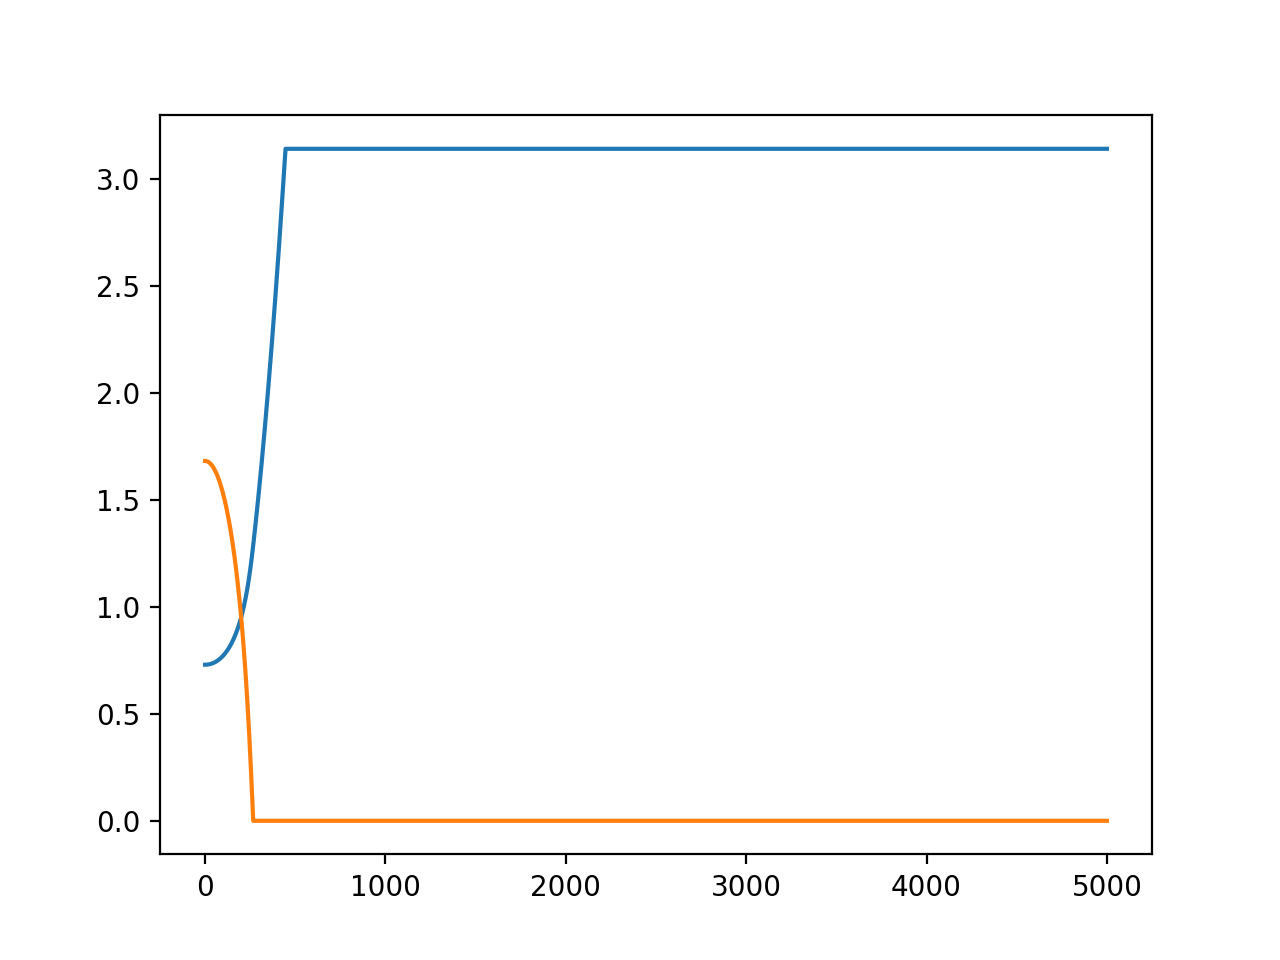

In [26]:
fig = plt.figure()
plt.plot(state_traj.squeeze()[:, 0])
plt.plot(state_traj.squeeze()[:, 1])
plt.show()

<IPython.core.display.Javascript object>


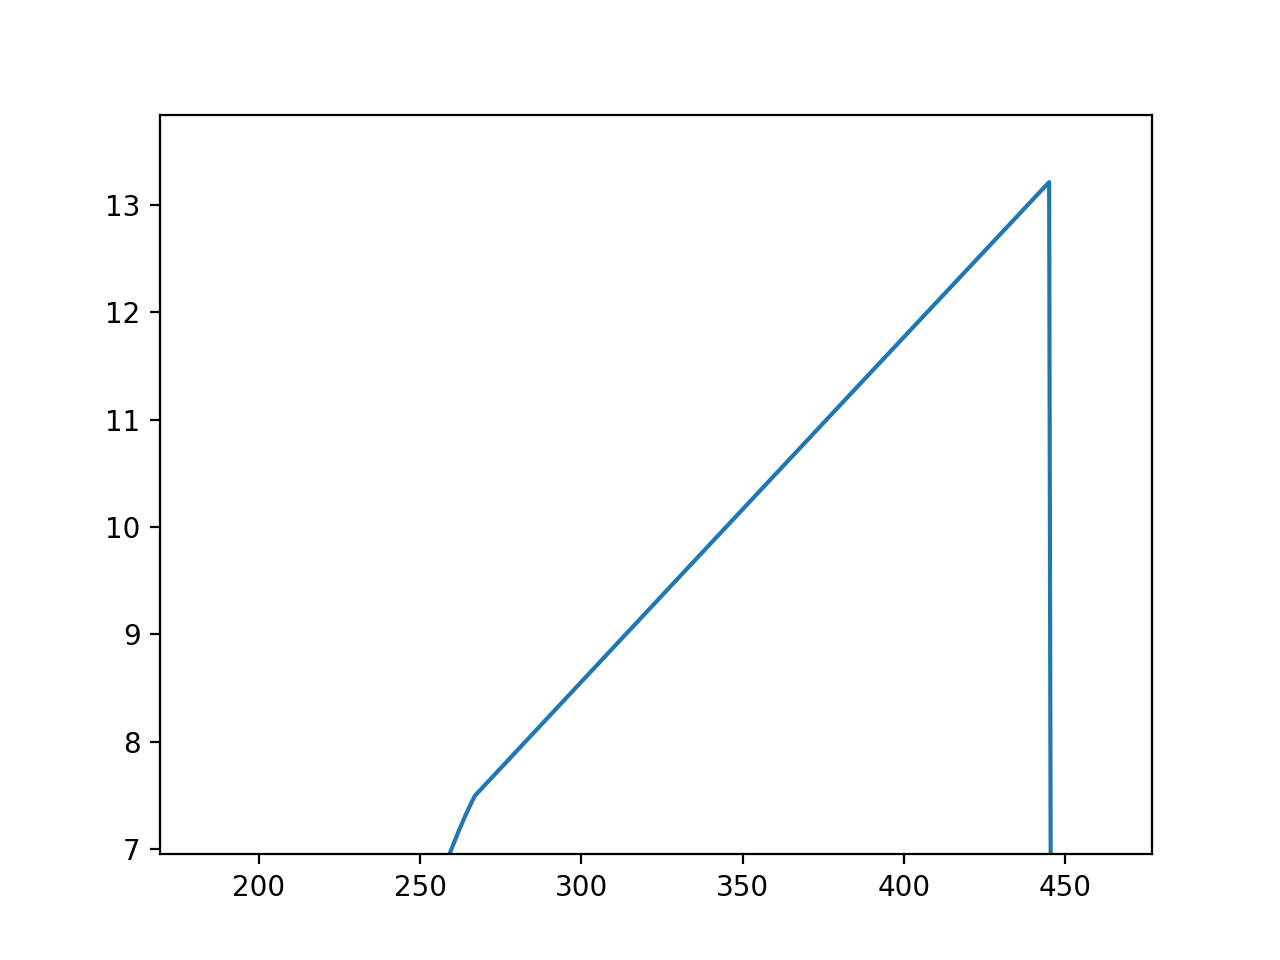

In [27]:
fig = plt.figure()
plt.plot(state_traj.squeeze()[:, 2])
plt.plot(state_traj.squeeze()[:, 3])
plt.show()

<IPython.core.display.Javascript object>


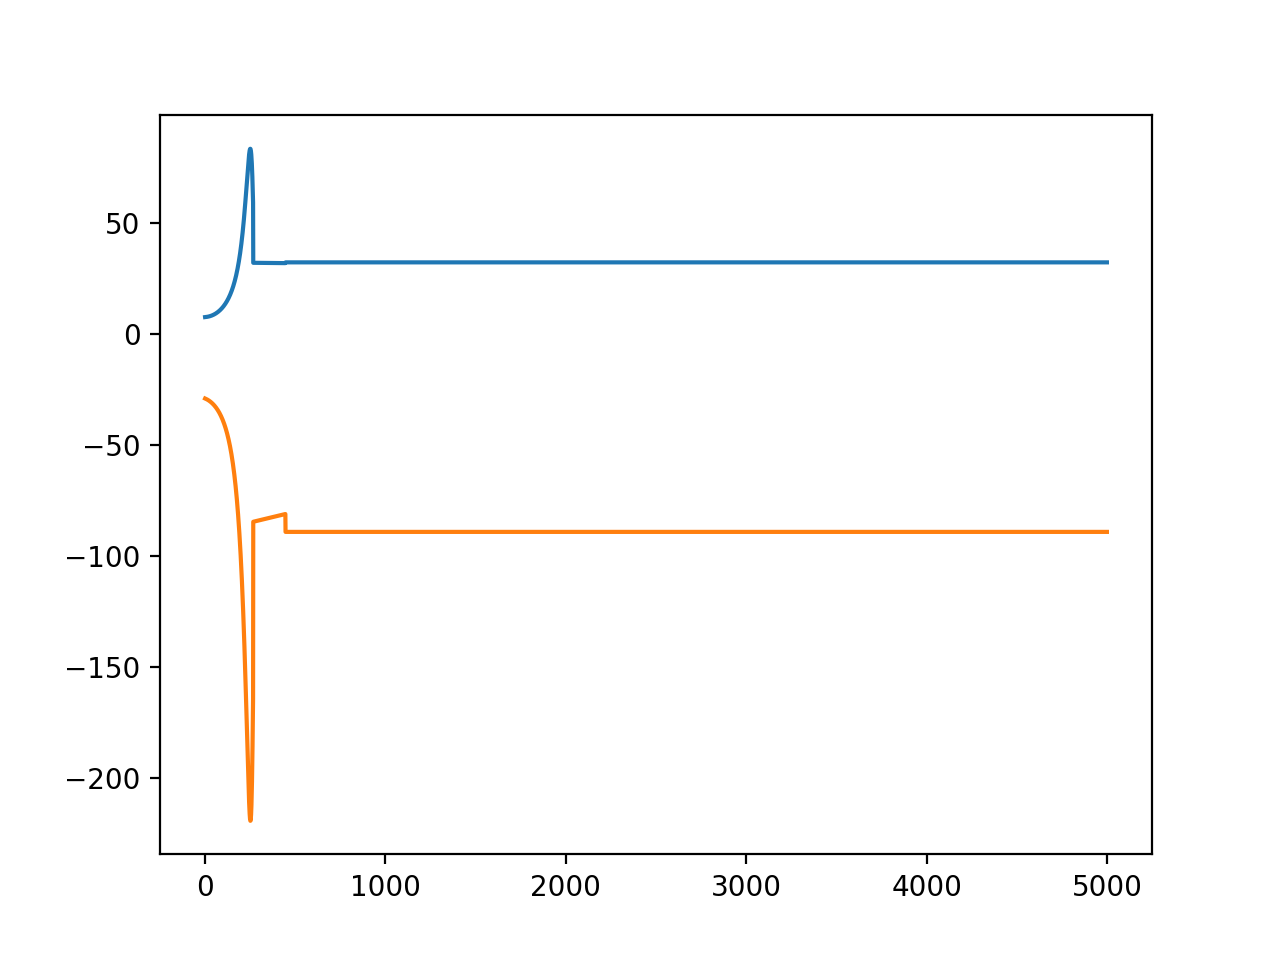

In [55]:
fig = plt.figure()
plt.plot(dstate_traj.squeeze()[:, 2])
plt.plot(dstate_traj.squeeze()[:, 3])
plt.show()

In [ ]:
"""
NOTE: Something weird about the dynamics of the arm. Once upper arm goes straight it seems to always fall
to the left. (i.e. state 0 deg, 0 deg seems to be unreachable - unstable).


NEW IMPLEMENTATION WITH M1 NEURON INTEGRATION BELOW!!!!!!!!!!!!!!!!!!!!!!!!!!
"""

In [2]:
# Class for storing Arm parameters
class M1ArmParams():
    def __init__(self):
        """
        """
        # Define physical properties of arm model
        #TODO: Make this an argument
        # arm lengths
        self.L1, self.L2 = 0.30, 0.30 #m
        # arm masses
        M1, M2 = 1.4, 1.0 #kg
        # moments of inertia
        I1, I2 = .025, .045 #kg/m^2
        # center of mass for lower arm
        D2 = .16 #m

        # constants for dynamics
        self.a1 = jnp.array(I1 + I2 + (M2*self.L1**2))
        self.a2 = jnp.array((M2*self.L1*D2))
        self.a3 = jnp.array(I2)

        # Constant damping matrix
        self.B = jnp.array(
            [(.05, .025),
            (.025, .05)]
        )

        # step size
        self.dt = .001

        # Initialize Task
        self.init_radial_task()
        
        # Add Theta Constraints
        self.max_theta = jnp.array([jnp.pi])
        self.min_theta = jnp.array([0.])
        
    # Define functions to calculate matrices for forward dynamics
    def calc_dyn_mats(self, theta1, theta2, dtheta1, dtheta2):
        """
        """
        # Update Matrix of inertia
        m_theta = jnp.array(
            [(self.a1+2*self.a2*jnp.cos(theta2), self.a3+arm_params.a2*jnp.cos(theta2)),
            (self.a3+self.a2*jnp.cos(theta2), self.a3)]
        )
        # Update Centripetal and Coriolis forces
        C = (self.a2*jnp.sin(theta2)) * jnp.array(
            [(-dtheta2*(2*dtheta1+dtheta2)), (dtheta1**2)]
        ).reshape(-1,1)

        return m_theta, C

    # Define function for calculating arm positions
    def calc_arm_pos(self, thetas):
        """
        """
        # Extract necessary state vars
        theta1, theta2 = thetas
        # Calculate positions and return
        elbow_pos = jnp.array([
            (self.L1*jnp.cos(theta1)), (self.L1*jnp.sin(theta1))
        ]).squeeze()
        
        hand_pos = jnp.array(
            [(elbow_pos[0] + self.L2*jnp.cos(theta1+theta2)),
             (elbow_pos[1] + self.L2*jnp.sin(theta1+theta2))]
        ).squeeze()

        return jnp.vstack([hand_pos, elbow_pos])
    
    def get_angles_from_pos(self, pos):
        """
        """
        x, y = pos
        theta1 = jnp.arctan2(y, x) - jnp.arccos((x**2 + y**2 + self.L1**2 - self.L2**2)
                                                         /(2*self.L1*(x**2 + y**2)**0.5))
        theta2 = jnp.arccos((x**2 + y**2 - self.L1**2 - self.L2**2)/(2*self.L1*self.L2))
        
        return theta1, theta2

    def init_radial_task(self, start_pos=jnp.array([0.0, 0.4]), radius=0.12):
        """
        """
        # Set starting positions
        x0, y0 = start_pos

        # Get target locations
        target_angles = jnp.array([0., 45., 90., 135., 180., 225., 270., 315.])*(2*jnp.pi/360)
        target_x = x0 + (jnp.cos(target_angles)*radius)
        target_y = y0 + (jnp.sin(target_angles)*radius)
        self.targets = jnp.concat([target_x[:, None], target_y[:, None]], axis=1) #m

        # Get initial angles from starting position
        theta1, theta2 = self.get_angles_from_pos(start_pos)
        self.init_thetas = jnp.vstack([theta1, theta2])
        
        # Store arm angles for targets
        target_t1, target_t2 = jax.vmap(self.get_angles_from_pos)(self.targets)
        self.target_angles = jnp.hstack([target_t1[:, None], target_t2[:, None]])

    def check_bounds(self, n_state):
        """
        Check if theta1 and theta2 are out of biomechanical-ish bounds.
        """

        # Check thetas against upper bound
        n_state = n_state.at[0].set(jax.lax.select(n_state[0] > self.max_theta, self.max_theta, n_state[0]))
        n_state = n_state.at[1].set(jax.lax.select(n_state[1] > self.max_theta, self.max_theta, n_state[1]))

        # Check thetas against lower bound
        n_state = n_state.at[0].set(jax.lax.select(n_state[0] < self.min_theta, self.min_theta, n_state[0]))
        n_state = n_state.at[1].set(jax.lax.select(n_state[1] < self.min_theta, self.min_theta, n_state[1]))

        # Set angular velocities to 0 if bounds are reached
        n_state = n_state.at[2].set(
            jax.lax.select(
                jnp.logical_or(n_state[0] == self.min_theta, n_state[0] == self.max_theta),
                jnp.array([0.]),
                n_state[2]
            )
        )
        n_state = n_state.at[3].set(
            jax.lax.select(
                jnp.logical_or(n_state[1] == self.min_theta, n_state[1] == self.max_theta),
                jnp.array([0.]),
                n_state[3]
            )
        )

        return n_state

    # Define dynamics step
    def update_state(self, state, torques):
        """
        """
        # extract state vars
        theta1, theta2, dtheta1, dtheta2 = state
        # Get only angular velocities
        dthetas = state[2:].reshape(-1, 1)
        # Update dynamics matrices
        m_theta, C = self.calc_dyn_mats(
            theta1.squeeze(), theta2.squeeze(), dtheta1.squeeze(), dtheta2.squeeze()
        )
        # Forward dynamics of torques applied to arm
        d2thetas = jnp.linalg.inv(m_theta) @ (torques - C + (self.B@dthetas))
        # New state
        dstate = jnp.vstack([dthetas, d2thetas])

        # Update state (TODO: May want to use a more powerful integration method)
        n_state = state + self.dt*dstate

        # Check Bounds and return new state
        return self.check_bounds(n_state)


    def plot_task_state(self, pos, ax=None):
        """
        """
        targets = self.targets * 100 #cm
        
        # Create figure if not given
        if ax == None:
            fig, ax = plt.subplots()
        else:
            ax.clear()
            
        # Convert positions to cm
        pos_cm = pos*100
        
        # Target locations
        ax.scatter(targets[:, 0], targets[:, 1], marker='s', color='green', s=200) #TODO, figure out how big these need to be

        # Start Locations
        ax.scatter(0., 0., color='red') # Shoulder
        ax.scatter(pos_cm[0, 0], pos_cm[0, 1], color='blue') # Hand
        ax.scatter(pos_cm[1, 0], pos_cm[1, 1], color='green') # Elbow

        # Make arms by connecting joints
        ax.plot([0., pos_cm[1, 0]], [0., pos_cm[1, 1]], color='blue') # Lower Arm
        ax.plot([pos_cm[0, 0], pos_cm[1, 0]], [pos_cm[0, 1], pos_cm[1, 1]], color='blue') # Upper Arm
        
        # Set axis boundaries
        ax.set_xlim([-60, 60])
        ax.set_ylim([-30, 60])
        
        if ax == None:
            plt.show()
        else:
            return ax

In [3]:
#NOTE: These might have to be Cost To Go
# I think they pass theta in becuase of whatever Q is. Cost matrix of some sort?
# Need to change dynamics to include the time t
def cost(t, arm_x, neur_inputs, torques, theta):
    """
    """
    arm_x0 = theta.arm.init_thetas
    target = theta.arm.target
    
    # target cost
    #TODO: Remove hard coding of delay period and T
    #T = dims.horizon - 300 #delay
    t_cost = jax.lax.select(
        t >= 300,
        ((t-300.)**2/900.**2) * jnp.linalg.norm(arm_x[:2]-target)**2,
        0.
    )
    
    # null cost
    alpha_null = 1.
    n_cost = alpha_null * jax.lax.select(
        t < 300,
        (
            jnp.linalg.norm(arm_x[:2]-arm_x0)**2 +
            jnp.linalg.norm(arm_x[2:])**2 +
            jnp.linalg.norm(torques)**2 
        ),
        0.
    )
    
    # effort cost
    #NOTE: Want to make this a penalty on the input derivative!
    alpha_effort = 5.e-7
    e_cost = (alpha_effort/len(neur_inputs)) * jnp.linalg.norm(neur_inputs)**2
    
    return t_cost + n_cost + e_cost

def costf(arm_final, target):
    """
    Think this is just the final cost
    """
    # target cost
    return jnp.linalg.norm(arm_final[:2]-target)**2
    
    

In [4]:
# Define dynamics step
# Add arm_params to theta, update arm state as arm_params
def m1_arm_step(t, m1_state, m1_u, theta):
    """
    """
    # Forward step M1 dynamics
    n_m1_state = (-1 * m1_state) + theta.Uh @ m1_state + theta.h + theta.Wh @ m1_u.reshape(-1,1)
    # Calculate torques from neural state
    torques = theta.C @ jax.nn.relu(n_m1_state)
    
    return n_m1_state, torques

In [5]:
# Create a new Theta Class
class M1Theta(NamedTuple):
#     def __init__(self, Uh, Wh, sigma, Q, C, h, arm):
    Uh : jax.Array
    Wh : jax.Array
    sigma : jax.Array
    Q : jax.Array
    C : jax.Array
    h : jax.Array
    arm : M1ArmParams
    

In [6]:
dims = ModelDims(horizon=1200, n=200, m=200, dt=0.001)

key = jr.PRNGKey(seed=234)
key, skeys = keygen(key, 5)

# TODO: Design Dynamics matrix using Schur Decomp
# Start with stable dynamics to see if even trainable
Uh = initialise_stable_dynamics(next(skeys), dims.n, dims.horizon, 0.6)[0]
# Identity for Input Matrix, B
Wh = jnp.identity(dims.m)
# Initialize Dynamics Parameters
#TODO: Add other dynamics parameters to theta
#TODO: Suggest to Tom to add __init__() to class defs so you can add extra attr if wanted
C = (.05/jnp.sqrt(dims.n)) * jr.normal(next(skeys), shape=(2, dims.n))
h = 5. + 5. * jr.normal(next(skeys), shape=(dims.n, 1))

arm_params = M1ArmParams()
arm_params.target = jr.choice(next(skeys), arm_params.target_angles).reshape(-1,1)

theta = M1Theta(
    Uh, Wh, jnp.zeros(dims.n), jnp.eye(dims.n), C, h, arm_params
)

# Create iLQR Params
params = iLQRParams(x0=jr.normal(next(skeys), (dims.n, 1)), theta=theta)
Us = jnp.zeros((dims.horizon, dims.m))   
# define linesearch hyper parameters
ls_kwargs = {
    "beta":0.8,
    "max_iter_linesearch":16,
    "tol":1e0,
    "alpha_min":0.0001,
    }

model = System(cost, costf, m1_arm_step, dims)

In [7]:
C.shape

(2, 200)

In [8]:
(opt_xs, opt_us, opt_lambdas), ilqr_fcost, cost_log = ilqr.ilqr_solver(
    model,
    params,
    Us,
    max_iter=70,
    convergence_thresh=1e-10,
    alpha_init=1.,
    verbose=True,
    use_linesearch=True,
    **ls_kwargs
)


AttributeError: 'NoneType' object has no attribute 'Uh'